In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist

In [3]:
scaler = StandardScaler()
pca = PCA()

In [4]:
full_df = pd.read_csv('../Data/career_pivot_results.csv')
print('Full Data Frame')
print(full_df.head())

Full Data Frame
  O*NET-SOC Code                                Title  A: Arm-Hand Steadiness  \
0     11-1011.00                     Chief Executives                    0.50   
1     11-1011.03        Chief Sustainability Officers                    0.00   
2     11-1021.00      General and Operations Managers                    0.88   
3     11-2011.00  Advertising and Promotions Managers                    0.50   
4     11-2021.00                   Marketing Managers                    0.12   

   A: Auditory Attention  A: Category Flexibility  A: Control Precision  \
0                   2.00                     4.00                  0.75   
1                   1.75                     3.50                  0.50   
2                   2.00                     3.25                  0.12   
3                   1.25                     3.88                  0.12   
4                   1.62                     3.62                  0.00   

   A: Deductive Reasoning  A: Depth Perception

In [5]:
# Keep only numeric columns for ML (exclude O*NET-SOC Code and Title)
numeric_df = full_df.select_dtypes(include=[np.number])
X = numeric_df.values

print(f"Shape: {X.shape}")
print(f"Numeric columns: {numeric_df.columns.tolist()[:5]}...")  # Show first 5

Shape: (894, 87)
Numeric columns: ['A: Arm-Hand Steadiness', 'A: Auditory Attention', 'A: Category Flexibility', 'A: Control Precision', 'A: Deductive Reasoning']...


In [6]:
# X_scaled = scaler.fit_transform(X)

# print("Original First Value:", X[0][0]) 

# # The scaled data (Z-score, usually between -2 and +2)
# print("Scaled First Value:", X_scaled[0][0])

# # Verify Mean is ~0 and Std is ~1
# print("New Mean:", X_scaled.mean().round(2))
# print("New Std:", X_scaled.std().round(2))

X_scaled=X

Variance explained by PC1: 54.65%
Variance explained by PC2: 16.40%
Variance explained by PC3: 5.58%
Total variance with 2 components: 71.05%
Total variance with 3 components: 76.63%


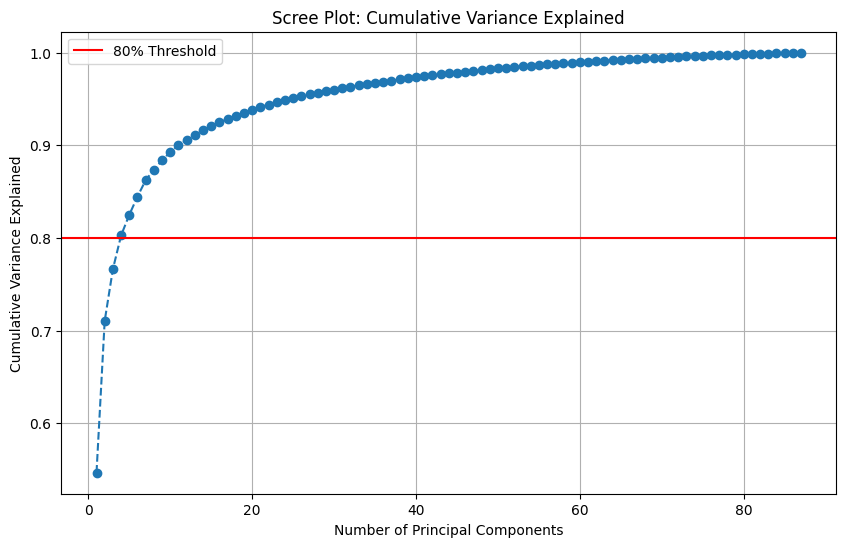

In [7]:
pca.fit(X_scaled)

evr = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(evr)

print(f"Variance explained by PC1: {evr[0]:.2%}")
print(f"Variance explained by PC2: {evr[1]:.2%}")
print(f"Variance explained by PC3: {evr[2]:.2%}")
print(f"Total variance with 2 components: {cumulative_variance[1]:.2%}")
print(f"Total variance with 3 components: {cumulative_variance[2]:.2%}")

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(evr) + 1), cumulative_variance, marker='o', linestyle='--')
plt.axhline(y=0.80, color='r', linestyle='-', label='80% Threshold')  # Threshold line
plt.title('Scree Plot: Cumulative Variance Explained')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Variance Explained')
plt.grid(True)
plt.legend()
plt.show()

In [8]:
feature_names = numeric_df.columns

loadings = pd.DataFrame(
    pca.components_, 
    columns=feature_names,
    index=[f'PC{i+1}' for i in range(len(pca.components_))]
)

def interpret_component(pc_name):
    print(f"*** {pc_name} Interpretation ***")
    
    # Sort values to find the strongest POSITIVE contributors
    top_pos = loadings.loc[pc_name].nlargest(5)
    print("Top Positive (High Values):")
    print(top_pos)
    print("-" * 20)
    
    # Sort values to find the strongest NEGATIVE contributors
    top_neg = loadings.loc[pc_name].nsmallest(5)
    print("Top Negative (Low Values):")
    print(top_neg)
    print("\n")

interpret_component('PC1')
interpret_component('PC2')
interpret_component('PC3')

*** PC1 Interpretation ***
Top Positive (High Values):
A: Multilimb Coordination    0.219762
A: Extent Flexibility        0.219546
A: Static Strength           0.215546
A: Reaction Time             0.212664
A: Control Precision         0.201450
Name: PC1, dtype: float64
--------------------
Top Negative (Low Values):
A: Written Expression      -0.138657
A: Written Comprehension   -0.118290
S: Writing                 -0.111496
S: Reading Comprehension   -0.102654
A: Oral Expression         -0.100255
Name: PC1, dtype: float64


*** PC2 Interpretation ***
Top Positive (High Values):
S: Science                     0.261365
A: Mathematical Reasoning      0.186522
S: Quality Control Analysis    0.167087
S: Operations Monitoring       0.160421
A: Visualization               0.159145
Name: PC2, dtype: float64
--------------------
Top Negative (Low Values):
A: Dynamic Flexibility       -0.011742
A: Trunk Strength            -0.008356
A: Stamina                   -0.006219
A: Dynamic Strength   

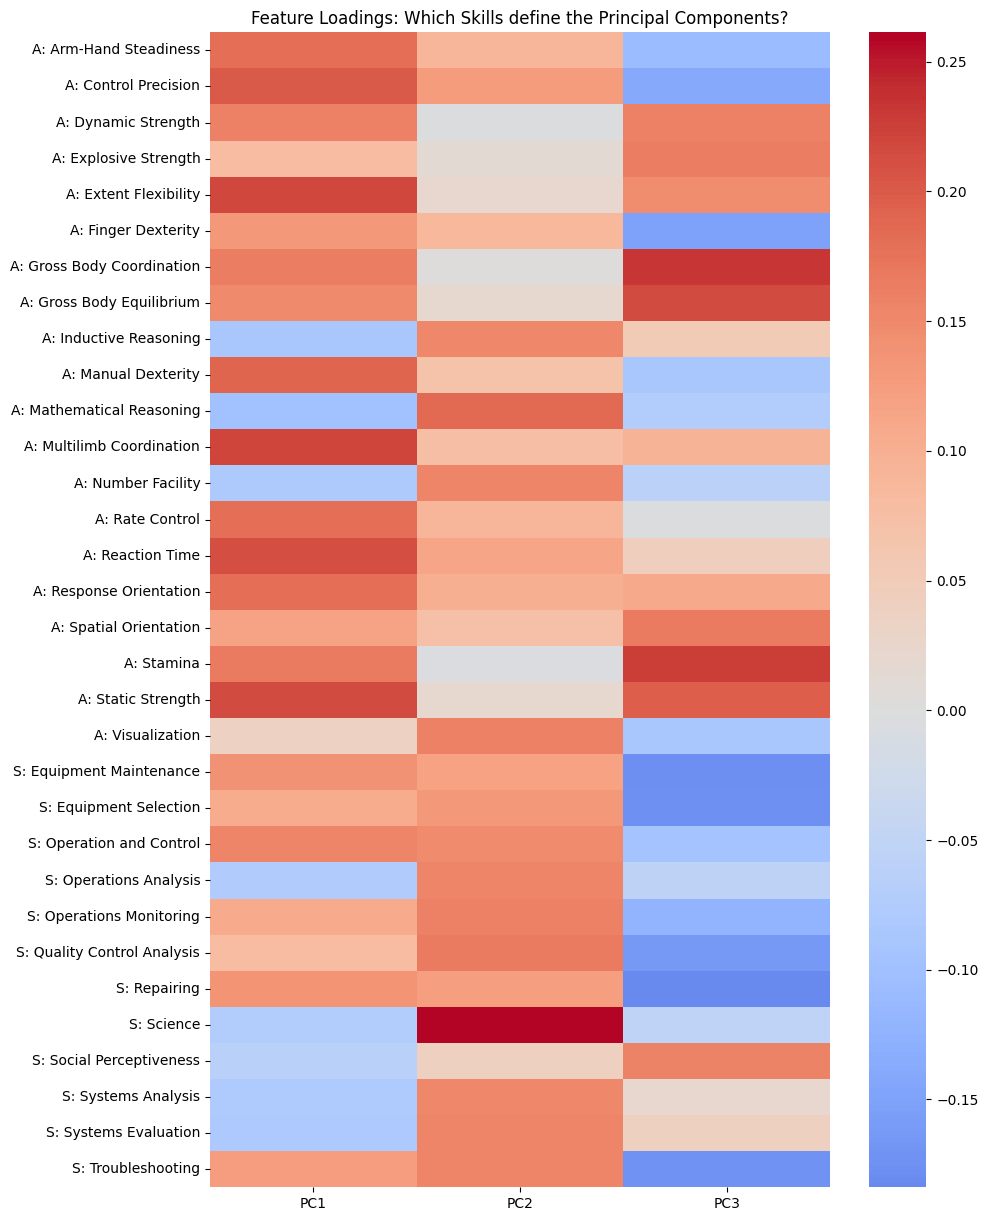

In [9]:
# Plot the top 3 Components and their relationship to a subset of skills
# We transpose (.T) so skills are on the side, PCs are on the bottom
plt.figure(figsize=(10, 15))

# We only pick the top 3 PCs to show in the chart
subset = loadings.iloc[:3].T 

# We filter to show only skills that have at least ONE strong connection (>0.15 or <-0.15)
# This removes "noise" skills that don't matter much
filtered_subset = subset[(subset.abs() > 0.15).any(axis=1)]

sns.heatmap(filtered_subset, cmap='coolwarm', center=0, annot=False)
plt.title("Feature Loadings: Which Skills define the Principal Components?")
plt.show()

Visualizing the Data in 2D space

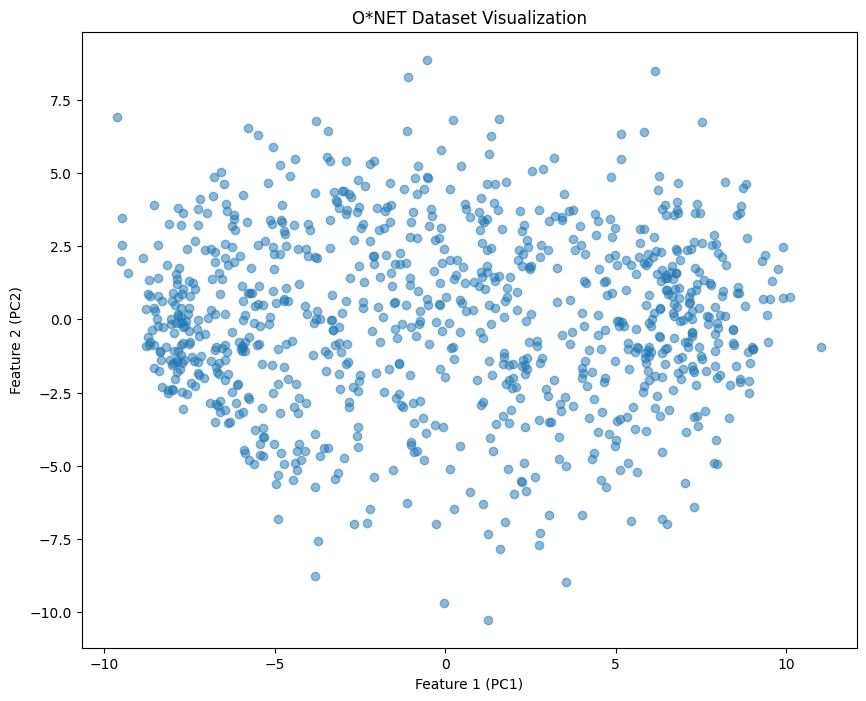

In [10]:
# 1. Create the 2 features (x1 and x2) from your real data
pca_simple = PCA(n_components=2)
coords = pca_simple.fit_transform(X_scaled)

x1 = coords[:, 0]  # This is your "Feature 1" (PC1)
x2 = coords[:, 1]  # This is your "Feature 2" (PC2)

# 2. Plot (Exactly your style)
plt.figure(figsize=(10, 8))
plt.scatter(x1, x2, marker='o', alpha=0.5) # alpha=0.5 makes it easier to see overlapping dots

plt.title('O*NET Dataset Visualization')
plt.xlabel('Feature 1 (PC1)')
plt.ylabel('Feature 2 (PC2)')
plt.show()

In [11]:
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 20)

for k in K:
    kmeanModel = KMeans(n_clusters=k,n_init=20, random_state=42).fit(X_scaled)
    
    distortions.append(sum(np.min(cdist(X_scaled, kmeanModel.cluster_centers_, 'euclidean'), axis=1)**2) / X_scaled.shape[0])
    inertias.append(kmeanModel.inertia_)
    
    mapping1[k] = distortions[-1]
    mapping2[k] = inertias[-1]

Distortion values:
1 : 54.42463995518841
2 : 31.489633846735458
3 : 26.895968182281027
4 : 23.40157793867668
5 : 21.619008428819544
6 : 20.199671125815218
7 : 19.27013216426726
8 : 18.5007358332441
9 : 17.911292177729155
10 : 17.436127485824258
11 : 16.900925942846982
12 : 16.48159398638451
13 : 16.104986303974844
14 : 15.746432825745137
15 : 15.389610126566847
16 : 15.07023875226718
17 : 14.939179446819457
18 : 14.58073076102648
19 : 14.354913525234684


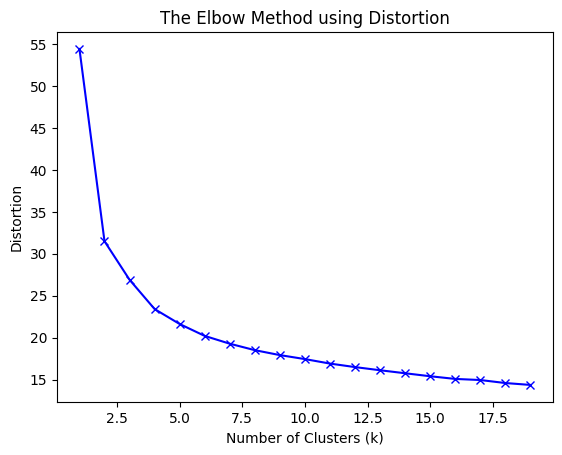

In [12]:
print("Distortion values:")
for key, val in mapping1.items():
    print(f'{key} : {val}')

plt.plot(K, distortions, 'bx-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

Inertia values:
1 : 48655.628119938476
2 : 28151.73265898153
3 : 24044.99555495925
4 : 20921.01067717695
5 : 19327.393535364652
6 : 18058.50598647879
7 : 17227.498154854926
8 : 16539.657834920246
9 : 16012.695206889835
10 : 15587.897972326902
11 : 15109.427792905213
12 : 14734.545023827743
13 : 14397.857755753515
14 : 14077.310946216161
15 : 13758.31145315077
16 : 13472.793444526847
17 : 13355.626425456601
18 : 13035.173300357685
19 : 12833.292691559802


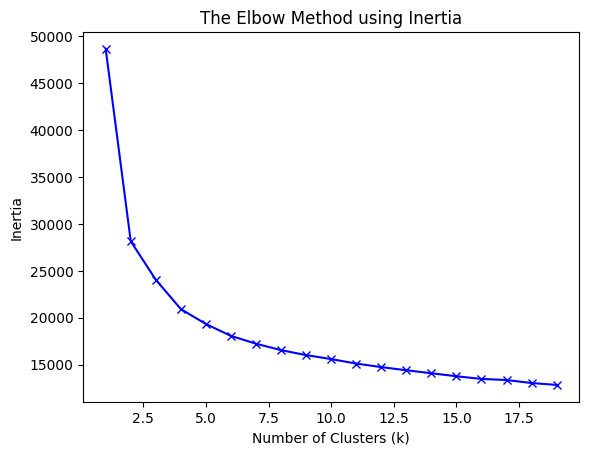

In [13]:
print("Inertia values:")
for key, val in mapping2.items():
    print(f'{key} : {val}')

plt.plot(K, inertias, 'bx-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.show()

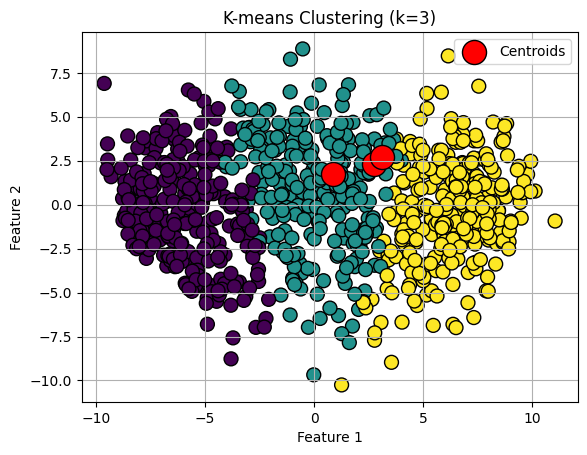

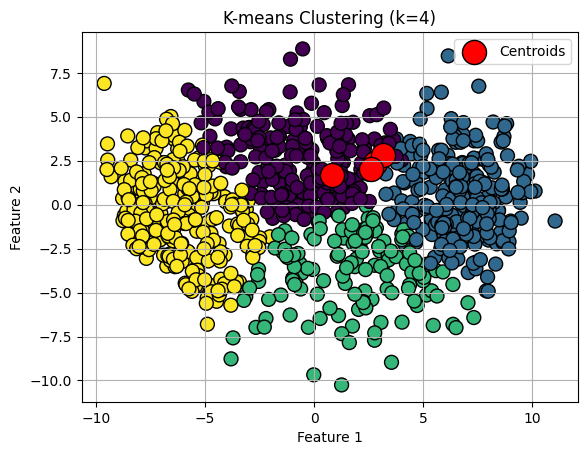

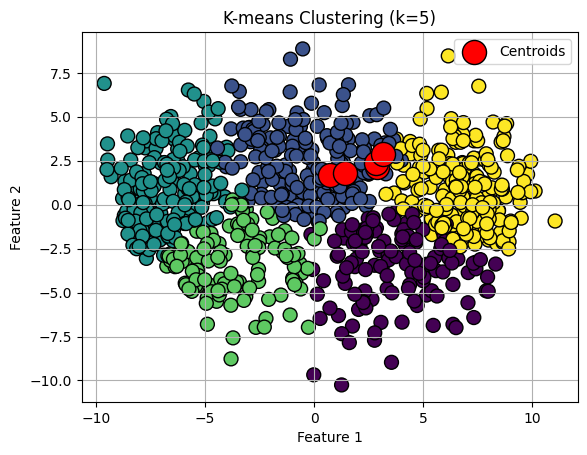

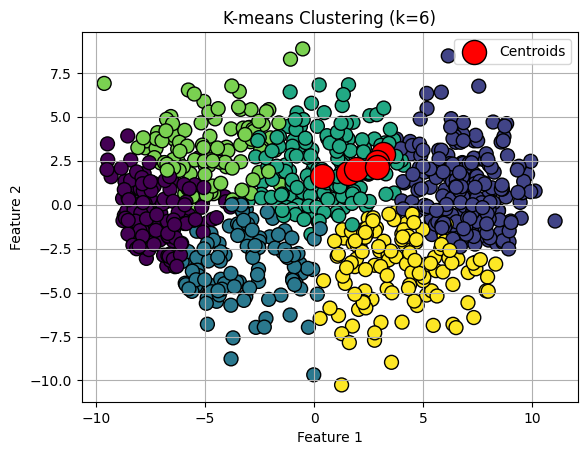

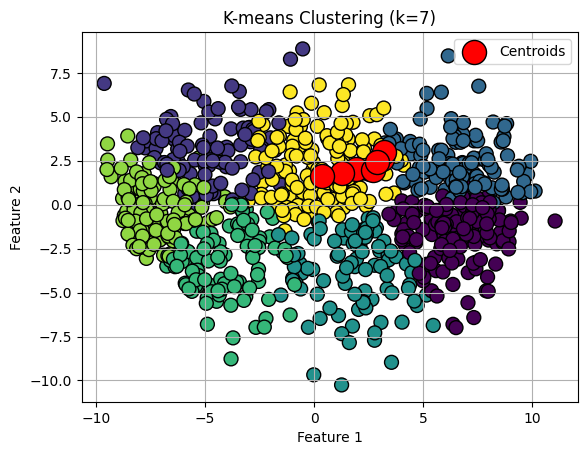

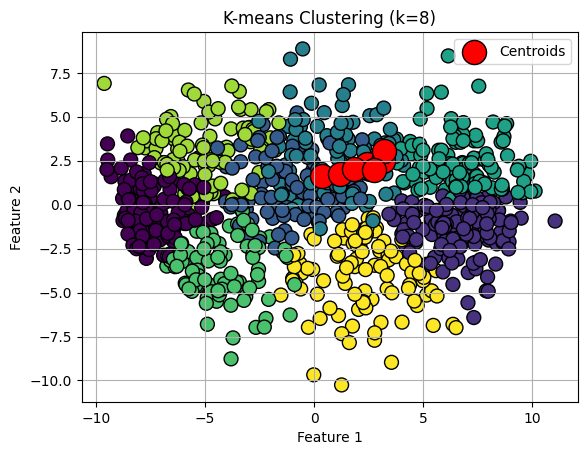

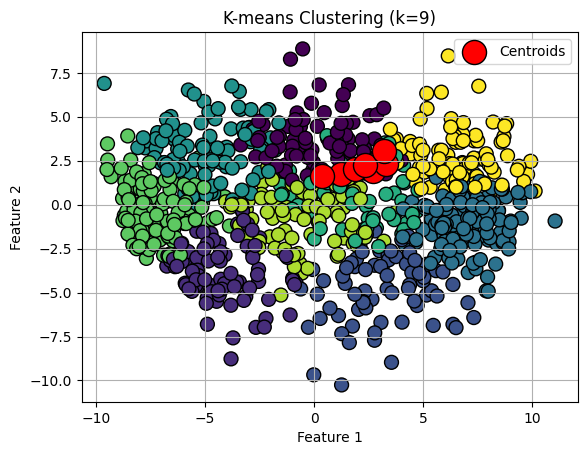

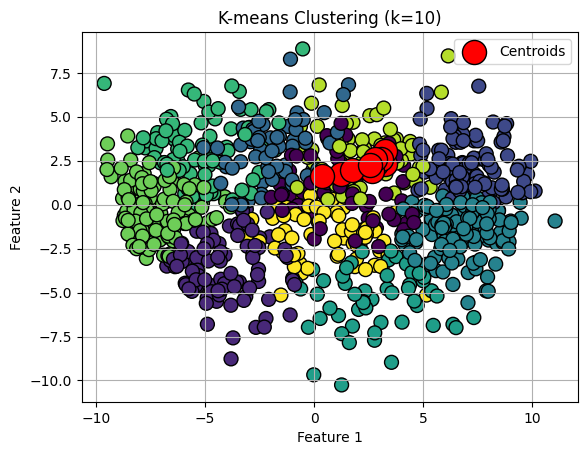

In [14]:
k_range = range(3, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, init='k-means++',n_init=20, random_state=42)
    y_kmeans = kmeans.fit_predict(X_scaled)
    
    plt.scatter(x1, x2, c=y_kmeans, cmap='viridis', marker='o', edgecolor='k', s=100)
    plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1],
                s=300, c='red', label='Centroids', edgecolor='k')
    plt.title(f'K-means Clustering (k={k})')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend()
    plt.grid()
    plt.show()

K means

In [15]:
k = 7

clusters = {}
np.random.seed(42)

for idx in range(k):
    center = 2*(2*np.random.random((X_scaled.shape[1],))-1)
    points = []
    cluster = {
        'center' : center,
        'points' : []
    }
    
    clusters[idx] = cluster
    
clusters

{0: {'center': array([-0.50183952,  1.80285723,  0.92797577,  0.39463394, -1.37592544,
         -1.37602192, -1.76766555,  1.46470458,  0.40446005,  0.83229031,
         -1.91766202,  1.87963941,  1.32977056, -1.15064356, -1.27270013,
         -1.26638196, -0.78303103,  0.09902573, -0.27221993, -0.83508344,
          0.44741158, -1.44202456, -0.83142141, -0.53455263, -0.17572006,
          1.14070385, -1.20130487,  0.05693775,  0.36965828, -1.81419835,
          0.43017941, -1.31790351, -1.73979363,  1.79554215,  1.86252813,
          1.23358939, -0.78154492, -1.60931154,  0.73693211, -0.23939003,
         -1.51184706, -0.01929236, -1.86244592,  1.63728161, -0.96488007,
          0.65008914, -0.7531557 ,  0.08027208,  0.18684112, -1.26058218,
          1.87833851,  1.10053129,  1.75799577,  1.5793094 ,  0.39159992,
          1.68749694, -1.64602999, -1.21606855, -1.81909084, -0.69867868,
         -0.44529084, -0.91460387,  1.31495004, -0.57298669, -0.87626196,
          0.17078433, -1.

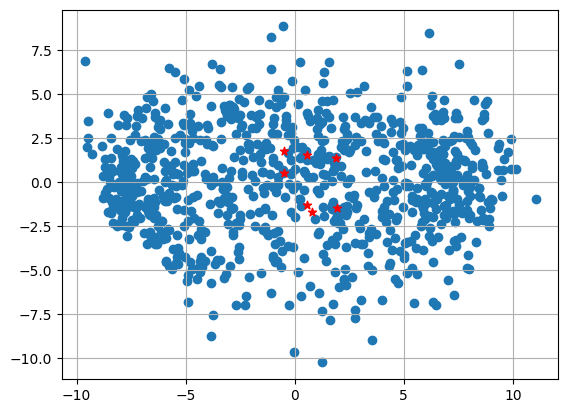

In [16]:
plt.scatter(x1,x2)
plt.grid(True)
for i in clusters:
    center = clusters[i]['center']
    plt.scatter(center[0],center[1],marker = '*',c = 'red')
plt.show()

In [17]:
def distance(p1,p2):
    return np.sqrt(np.sum((p1-p2)**2))

In [18]:
def assign_clusters(X, clusters):
    for idx in range(X.shape[0]):
        dist = []
        
        curr_x = X[idx]
        
        for i in range(k):
            dis = distance(curr_x,clusters[i]['center'])
            dist.append(dis)
        curr_cluster = np.argmin(dist)
        clusters[curr_cluster]['points'].append(curr_x)
    return clusters

def update_clusters(X, clusters):
    for i in range(k):
        points = np.array(clusters[i]['points'])
        if points.shape[0] > 0:
            new_center = points.mean(axis =0)
            clusters[i]['center'] = new_center
            
            clusters[i]['points'] = []
    return clusters

In [19]:
def pred_cluster(X, clusters):
    pred = []
    for i in range(X.shape[0]):
        dist = []
        for j in range(k):
            dist.append(distance(X[i],clusters[j]['center']))
        pred.append(np.argmin(dist))
    return pred

In [20]:
clusters = assign_clusters(X_scaled,clusters)
clusters = update_clusters(X_scaled,clusters)
pred = pred_cluster(X_scaled,clusters)

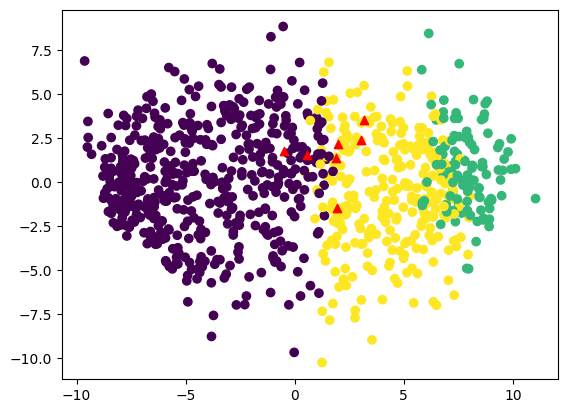

In [21]:
plt.scatter(x1,x2,c = pred)
for i in clusters:
    center = clusters[i]['center']
    plt.scatter(center[0],center[1],marker = '^',c = 'red')
plt.show()